In [0]:
#img_dir zmenit podla toho kde sa nachadza dbs obrazkov
img_dir = "/content/drive/My Drive/Colab Notebooks/CelebA-small" # Enter Directory of all images
data_path = os.path.join(img_dir, '*g')
files = glob.glob(data_path)
name = ""
data = {}

for f1 in files[:6000]:
    name = f1.split('/')[6].strip()
    img = cv2.imread(f1)
    data[name] = img

truth={}
with open('list_bbox_celeba.txt', 'r') as f:
    lines = f.readlines()[2:]    
for line in lines:
    line = re.sub(' +',';', line[:-1])
    truthpole=line.split(";")
    truth[truthpole[0]] = list(map(int, truthpole[1:]))


In [0]:
predicted={}
with open('list_landmarks_celeba.txt', 'r') as f:
    lines = f.readlines()[2:]  

for line in lines:
    line = re.sub(' +', ';', line[:-1])
    predictedPole =line.split(";")
    predicted[predictedPole[0]] = list(map(int, predictedPole[1:]))

In [0]:
from itertools import islice
from google.colab.patches import cv2_imshow

desiredLeftEye=(0.38, 0.38)

for key in data:
    img = data[key]  
    coordinates = predicted[key]
    leftEyeX,leftEyeY = coordinates[0],coordinates[1]
    rightEyeX,rightEyeY =coordinates[2],coordinates[3]
    
    dY = rightEyeY - leftEyeY
    dX = rightEyeX - leftEyeX
    
    angle = np.degrees(np.arctan2(dY, dX))
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= 300 #256pixelov
    scale = desiredDist / dist
    eyesCenter = ((leftEyeX + rightEyeX) // 2,(leftEyeY + rightEyeY) // 2)
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
    tX = 300 * 0.5
    tY = 300 * desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])
    (w, h) = (300, 300)
    output = cv2.warpAffine(img, M, (w, h),flags=cv2.INTER_CUBIC)
    cv2.imwrite('/content/drive/My Drive/Colab Notebooks/CelebA-small-resized/'+ key,output)
    #cv2_imshow(img)
    #cv2_imshow(output)
    #cv2.waitKey(0)
    
cv2.destroyAllWindows()

In [0]:
#img_dir zmenit podla toho kde sa nachadza dbs obrazkov
img_dir = "/content/drive/My Drive/Colab Notebooks/CelebA-small-resized" # Enter Directory of all images
data_path = os.path.join(img_dir, '*g')
files = glob.glob(data_path)
name = ""
data = {}


In [0]:
for f1 in files[:len(files)]:
    name = f1.split('/')[6].strip()
    img = cv2.imread(f1)
    data[name] = img

In [0]:
import numpy as np
import cv2
import os
import glob 
import re
import pickle
from skimage.feature import local_binary_pattern
# To calculate a normalized histogram 
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize

from skimage.feature import hog
from skimage import exposure
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from skimage.color import rgb2gray

import pandas as pd
from random import randint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
random_state = np.random.RandomState(0)
from sklearn.metrics import roc_curve, auc
import pylab as pl

In [0]:

with open('/content/drive/My Drive/Colab Notebooks/images.pickle', 'wb') as file:
  pickle.dump(data, file)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/images.pickle', 'rb') as file:
  data = pickle.load(file)

In [0]:


dataTvar = pd.read_csv('identity_CelebA.txt', sep=" ", header=None)
dataTvar.columns = ["fotka", "identita"]
dataTvar = dataTvar[dataTvar['fotka'].isin(list(data.keys()))]
truepair = []
impostor = []
print(dataTvar)
for index, row in dataTvar.iterrows():
  iden_find = dataTvar.identita == row.identita
  fotka_find = dataTvar.fotka != row.fotka
  row_find = dataTvar[iden_find & fotka_find]
  if(not row_find.empty):
    #print(index, row_find.fotka.iloc[0])
    truepair.append((row.fotka, row_find.fotka.iloc[0]))
    
  iden_not_find = dataTvar.identita != row.identita
  row_not_find = dataTvar[iden_not_find & fotka_find]
  impostor.append((row.fotka, row_not_find.fotka.iloc[randint(0, len(row_not_find.fotka) - 1)]))

             fotka  identita
92      000093.jpg      7399
113     000114.jpg      7256
130     000131.jpg      7222
148     000149.jpg      7284
175     000176.jpg      7434
...            ...       ...
202522  202523.jpg      7362
202523  202524.jpg      7397
202533  202534.jpg      7438
202563  202564.jpg      7206
202567  202568.jpg      7241

[6000 rows x 2 columns]


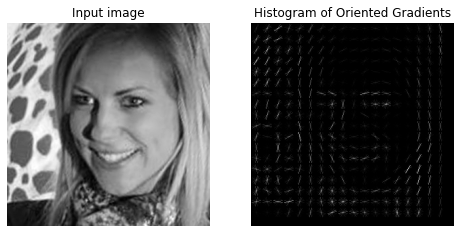

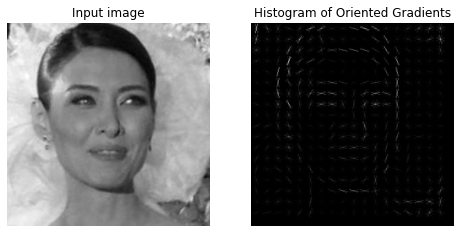

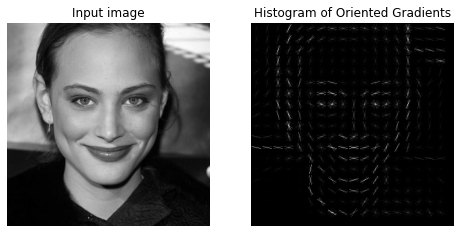

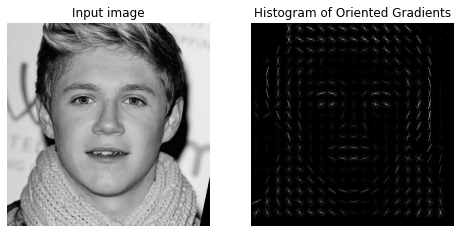

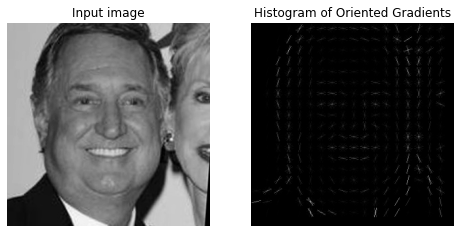

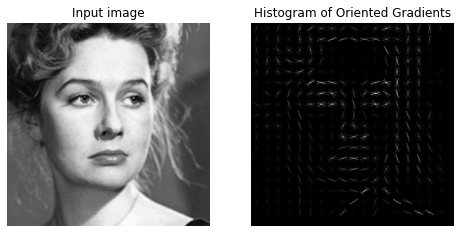

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


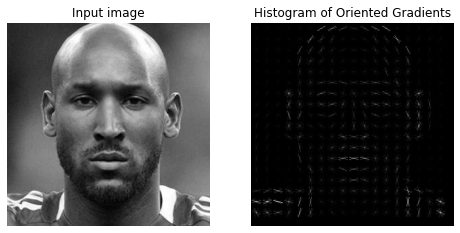

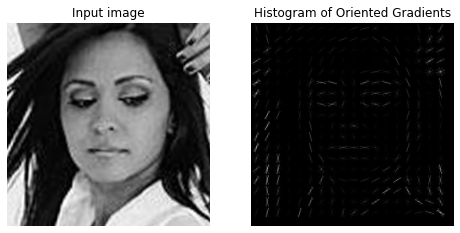

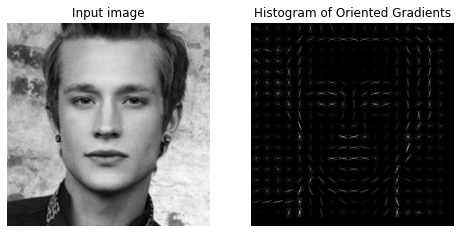

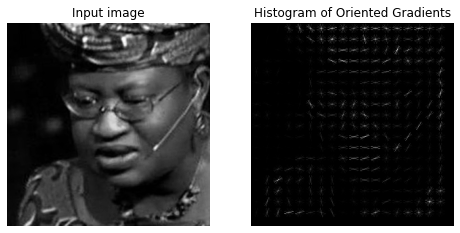

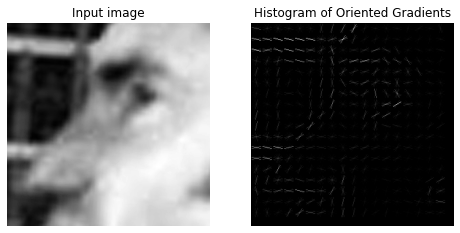

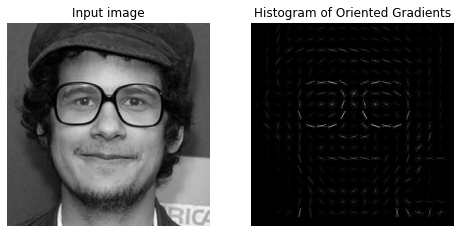

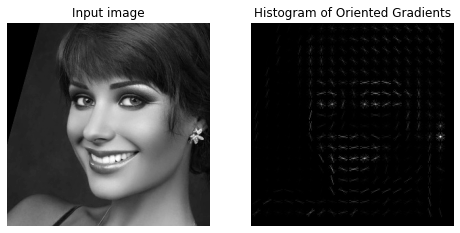

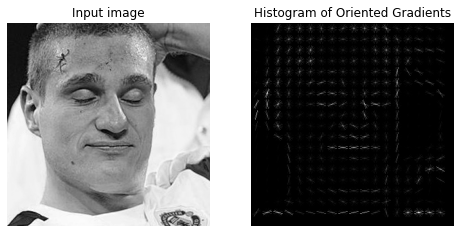

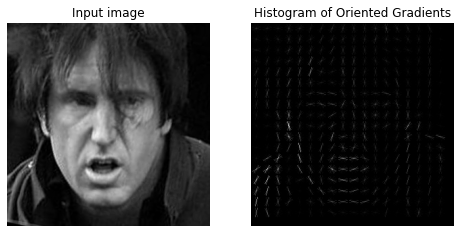

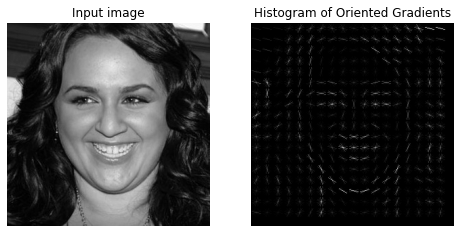

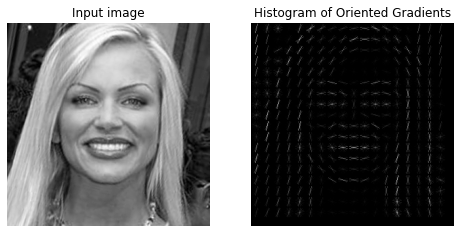

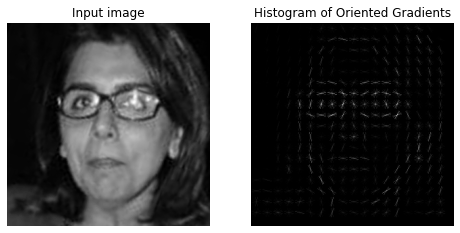

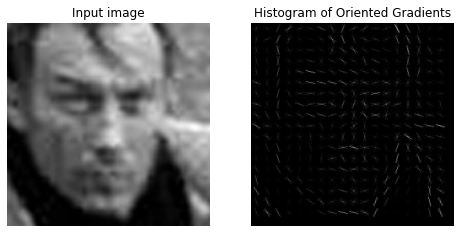

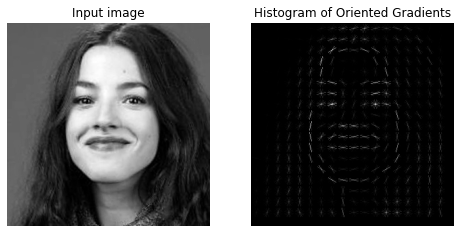

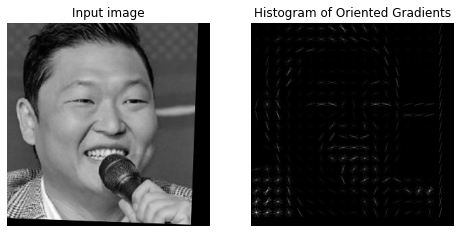

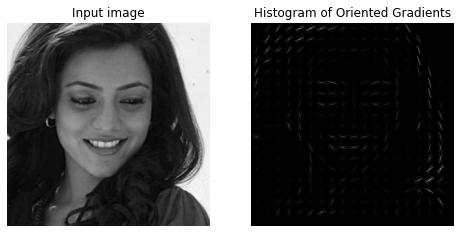

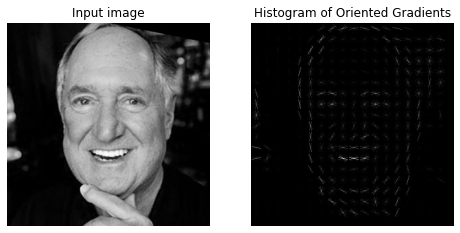

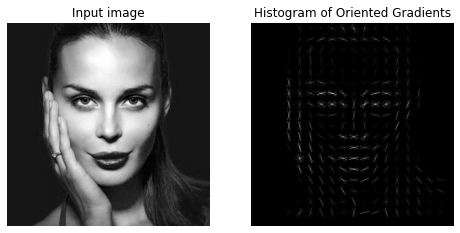

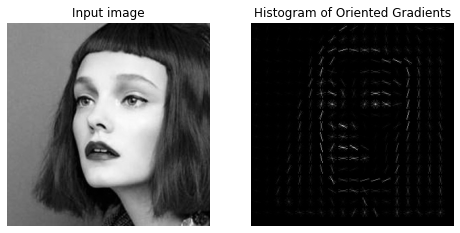

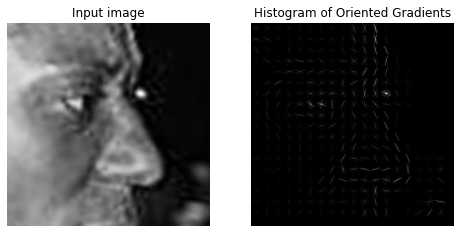

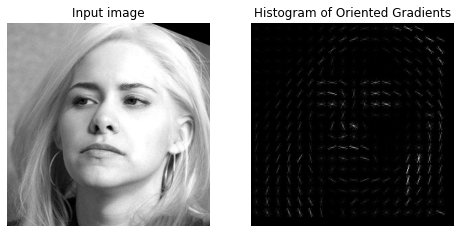

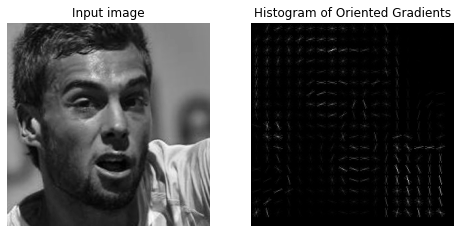

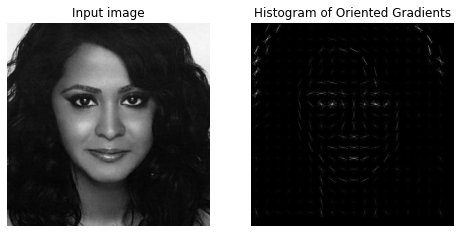

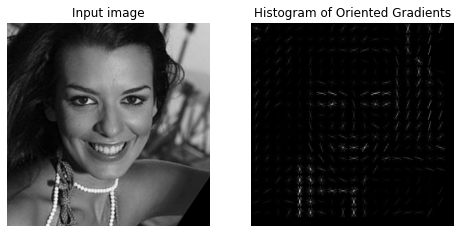

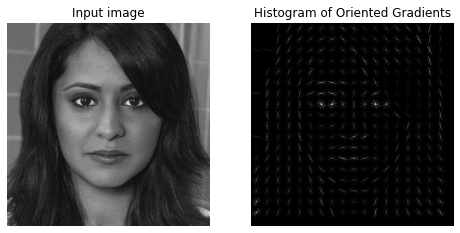

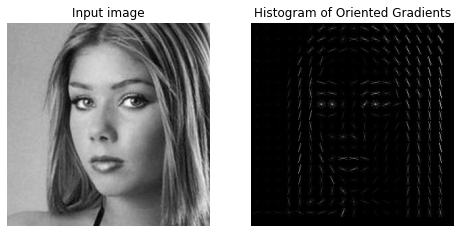

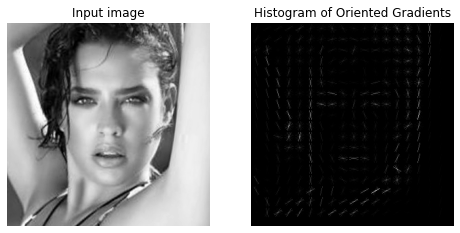

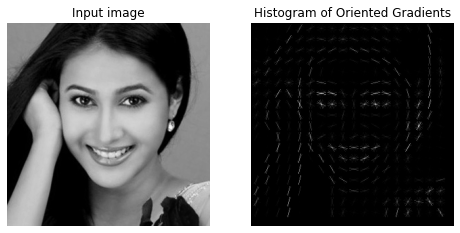

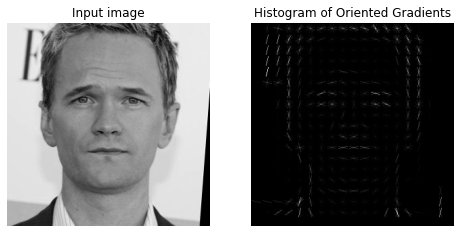

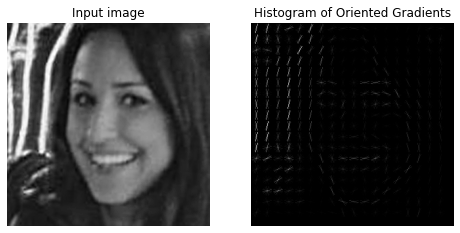

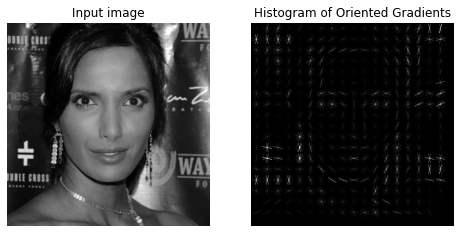

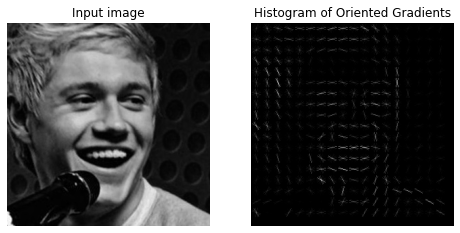

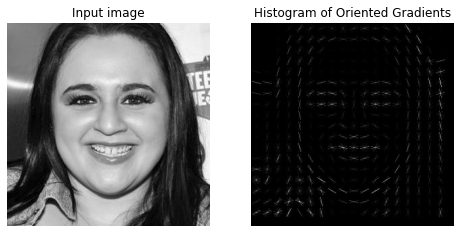

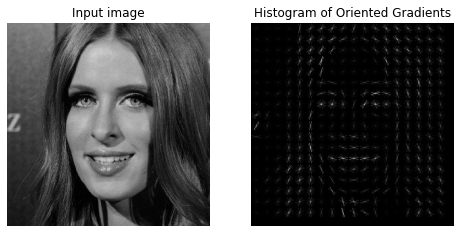

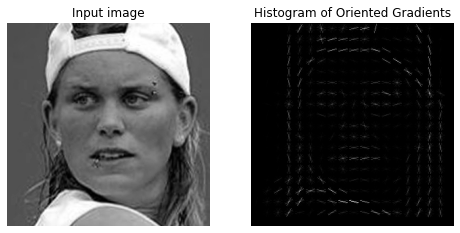

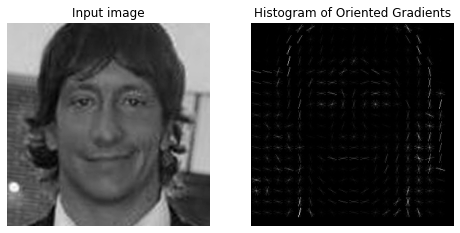

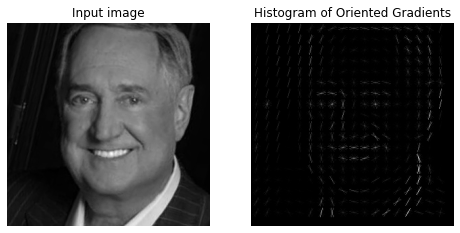

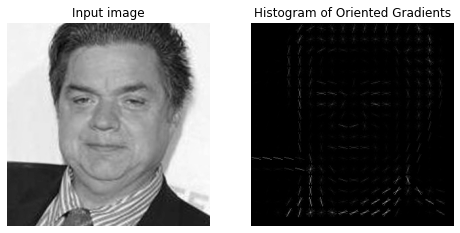

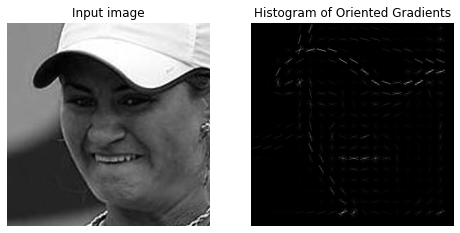

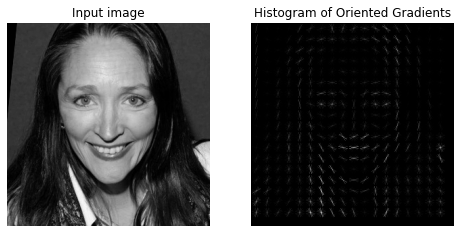

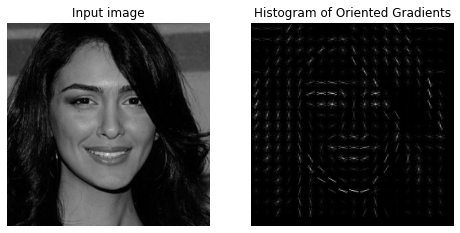

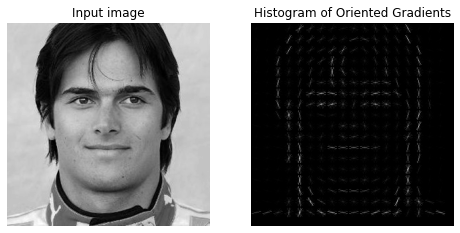

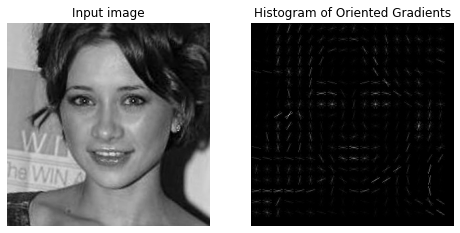

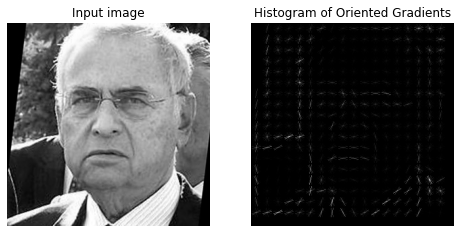

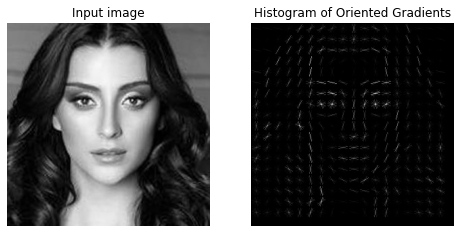

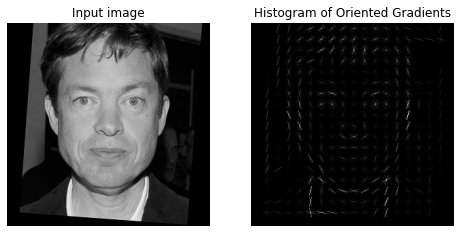

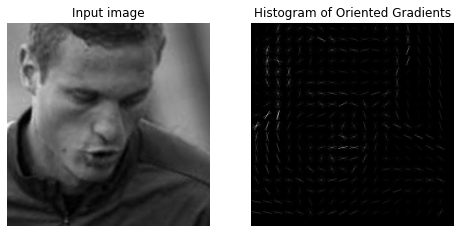

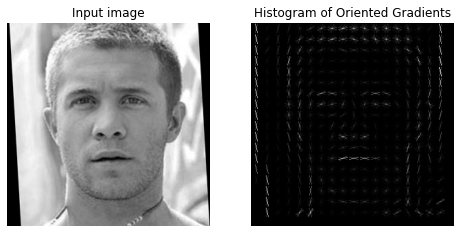

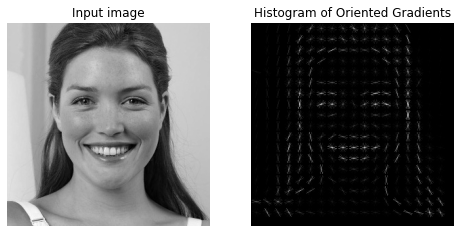

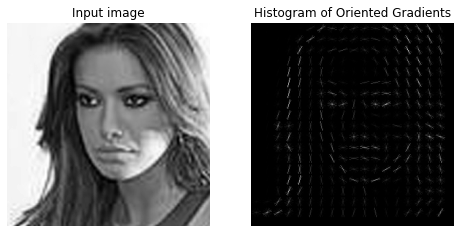

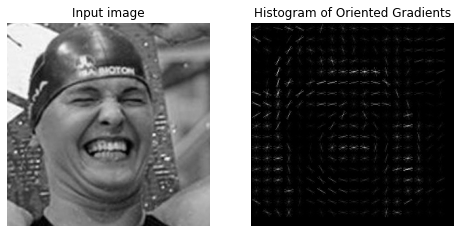

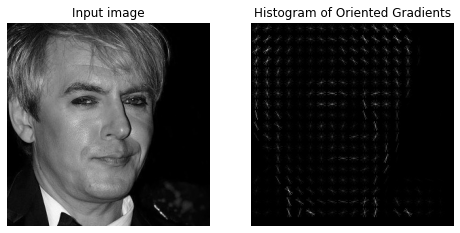

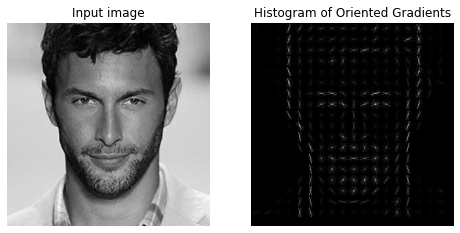

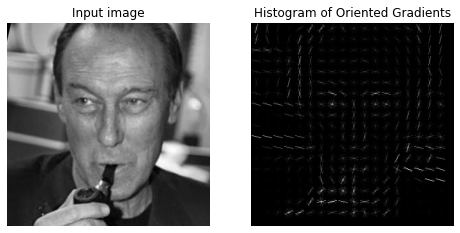

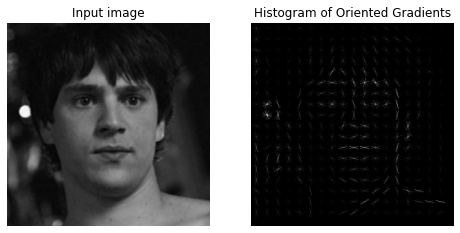

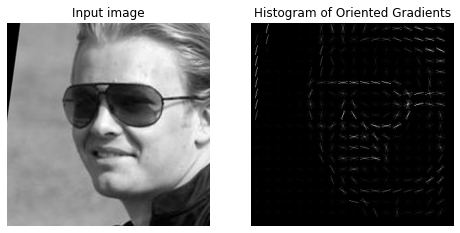

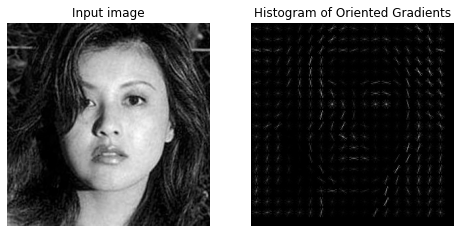

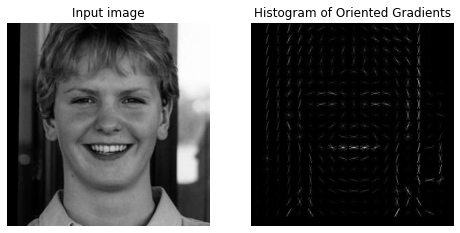

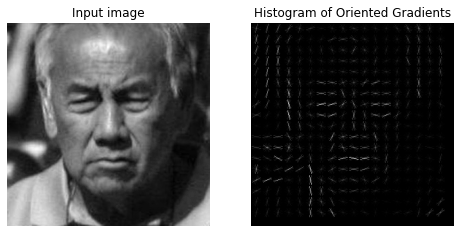

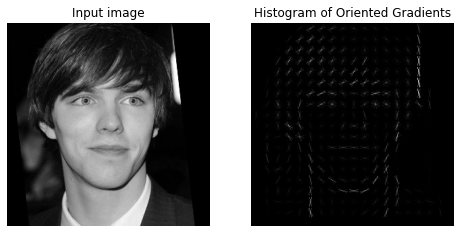

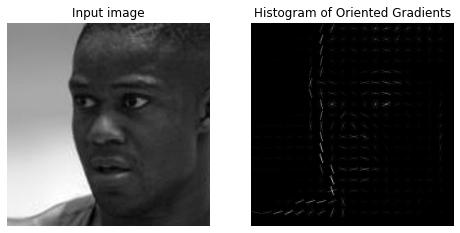

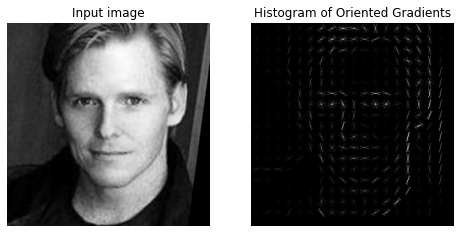

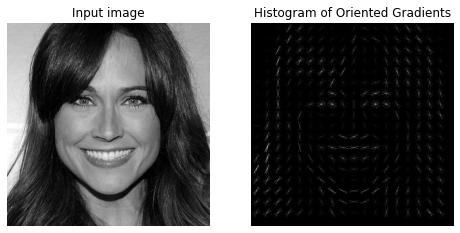

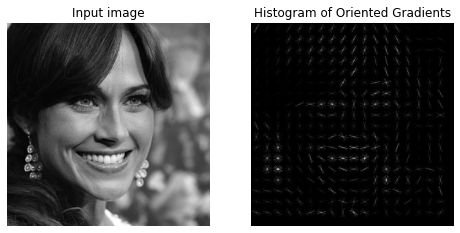

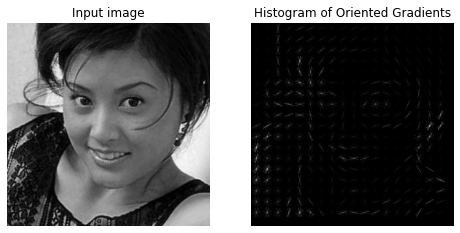

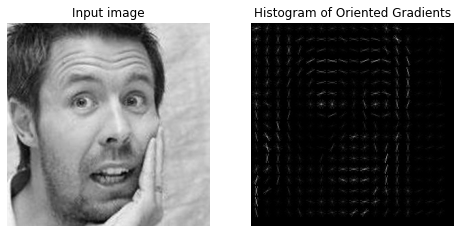

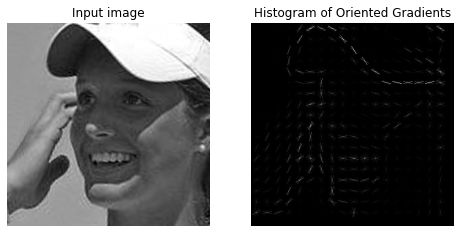

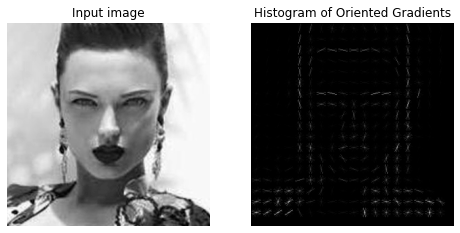

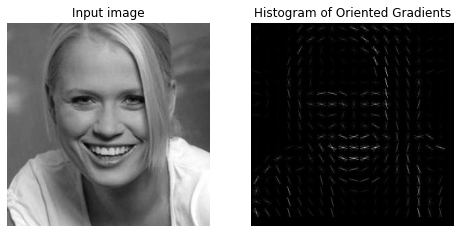

In [0]:


hog_face_features={}
hog_face_images=[]
for key in data:
    rgbimg = data[key]
    img = rgb2gray(rgbimg)  
    featuresHog, hogimage = hog(img, orientations=8, pixels_per_cell=(16, 16),
                     cells_per_block=(1, 1),block_norm= 'L2', visualize=True, multichannel=False)
    hog_face_features[key] = list(map(float, featuresHog))

    #hog_face_features.append(featuresHog)
    hog_face_images.append(hogimage)

labelsunique =  np.array(dataTvar['identita'].unique()).reshape(len(dataTvar['identita'].unique()),1)
labels = np.array(dataTvar['identita']).reshape(len(dataTvar['identita']),1)

trueidentity = []
falseidentity = []
for pair in truepair:
  prvy = hog_face_features.get(pair[0])
  druhy = hog_face_features.get(pair[1])
  new_data = np.concatenate((prvy,druhy), axis=0)
  means = np.mean(new_data, axis=0)
  vars = np.var(new_data, axis=0)
  norm_data = (new_data - means) / vars
  trueidentity.append(norm_data)

for pair in impostor:
  prvy = hog_face_features.get(pair[0])
  druhy = hog_face_features.get(pair[1])
  new_data = np.concatenate((prvy,druhy), axis=0)
  means = np.mean(new_data, axis=0)
  vars = np.var(new_data, axis=0)
  norm_data = (new_data - means) / vars
  falseidentity.append(norm_data)

In [0]:


clf = svm.SVC(kernel='rbf', probability=True, verbose=1)
hog_features = np.vstack((trueidentity, falseidentity)).astype(np.float64)
scaler = StandardScaler().fit(hog_features)
x = scaler.transform(hog_features)
y = np.hstack((np.ones(len(trueidentity)), np.zeros(len(falseidentity))))
x, y = shuffle(x, y, random_state=random_state)

#data_frame = np.hstack((x,y))
#np.random.shuffle(data_frame)

# Training Features...
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
probas_ = clf.fit(x_train,y_train).predict_proba(x_test)
y_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

[LibSVM]Accuracy: 0.9295833333333333


              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      1206
         1.0       0.93      0.93      0.93      1194

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400



In [0]:
!pip install opencv-contrib-python

In [0]:
#from pyimagesearch.localbinarypatterns import LocalBinaryPatterns
#desc = LocalBinaryPatterns(24, 8)
LBP_face_features={}
for key in data:
  rgbimg = data[key]
  img = rgb2gray(rgbimg) 
  radius = 3
  no_points = 8 * radius
  lbp = local_binary_pattern(img, no_points, radius, method='uniform')
  x = itemfreq(lbp.ravel())
  hist = x[:, 1]/sum(x[:, 1])
  LBP_face_features[key] = list(map(float, hist))


LBPtrueidentity = []
LBPfalseidentity = []
for pair in truepair:
  prvy = LBP_face_features.get(pair[0])
  druhy = LBP_face_features.get(pair[1])
  new_data = np.concatenate((prvy,druhy), axis=0)
  LBPtrueidentity.append(new_data)

for pair in impostor:
  prvy = LBP_face_features.get(pair[0])
  druhy = LBP_face_features.get(pair[1])
  new_data = np.concatenate((prvy,druhy), axis=0)
  LBPfalseidentity.append(new_data)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  # This is added back by InteractiveShellApp.init_path()


In [0]:
random_state = np.random.RandomState(0)

clf = svm.SVC(kernel='rbf', probability=True, verbose=1)
LBP_features = np.vstack((LBPtrueidentity, LBPfalseidentity)).astype(np.float64)
scaler = StandardScaler().fit(LBP_features)
x = scaler.transform(LBP_features)
y = np.hstack((np.ones(len(LBPtrueidentity)), np.zeros(len(LBPfalseidentity))))
x, y = shuffle(x, y, random_state=random_state)


# Training Features...
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
probas_ = clf.fit(x_train,y_train).predict_proba(x_test)
y_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

[LibSVM]Accuracy: 0.6304166666666666


              precision    recall  f1-score   support

         0.0       0.64      0.56      0.60      1182
         1.0       0.62      0.70      0.66      1218

    accuracy                           0.63      2400
   macro avg       0.63      0.63      0.63      2400
weighted avg       0.63      0.63      0.63      2400



In [0]:
labelsunique =  np.array(dataTvar['identita']).reshape(len(dataTvar['identita']),1)
kebydaco =dataTvar['identita'].to_numpy()

In [0]:
len(data)

6000

In [0]:
  rgbimg = data
  img = rgb2gray(rgbimg) 
  pca = PCA(n_components = 0.95)
  pcafeature = pca.fit(img)
  reduced = pca.transform(img)


In [0]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

PCA_face_features={}
PCA_face_reduced={}

rgb_img_values = data.values()
rgb_img_keys = data.keys()

gray_img_values = []
for rgb_img in rgb_img_values:
  gray_img_values.append(rgb2gray(rgb_img))

pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(gray_img_values, rgb_img_keys, test_size=0.2)

pca = PCA(n_components = 0.95)
pcafeature = pca.fit(pca_X_train)

pca_X_t_train = pca.transform(pca_X_train)
pca_X_t_test = pca.transform(pca_X_test)
pca_clf = SVC()
pca_clf.fit(pca_X_t_train, pca_y_train)
print('score', pca_clf.score(pca_X_t_test, pca_y_test))
print('pred label', pca_clf.predict(pca_X_t_test))

# for key in data:
#     rgbimg = data[key]
#     img = rgb2gray(rgbimg) 
#     pca = PCA(n_components = 0.95)
#     pcafeature = pca.fit(img)
#     reduced = pca.transform(img)
#     #PCA_face_features[key] = list(map(float, reduced))
#     plt.imshow(img,
#            cmap=plt.cm.bone)
#     #PCA_face_reduced[key] = list(map(float, reduced.components_))

# PCAtrueidentity = []
# PCAfalseidentity = []
# for pair in truepair:
#   prvy = PCA_face_features.get(pair[0])
#   druhy = PCA_face_features.get(pair[1])
#   new_data = np.concatenate((prvy,druhy), axis=0)
#   means = np.mean(new_data, axis=0)
#   vars = np.var(new_data, axis=0)
#   norm_data = (new_data - means) / vars
#   PCAtrueidentity.append(norm_data)

# for pair in impostor:
#   prvy = PCA_face_features.get(pair[0])
#   druhy = PCA_face_features.get(pair[1])
#   new_data = np.concatenate((prvy,druhy), axis=0)
#   means = np.mean(new_data, axis=0)
#   vars = np.var(new_data, axis=0)
#   norm_data = (new_data - means) / vars
#   PCAfalseidentity.append(norm_data)



In [0]:
random_state = np.random.RandomState(0)

clf = svm.SVC(kernel='rbf', probability=True, verbose=1)
LBP_features = np.vstack((LBPtrueidentity, LBPfalseidentity)).astype(np.float64)
scaler = StandardScaler().fit(LBP_features)
x = scaler.transform(LBP_features)
y = np.hstack((np.ones(len(LBPtrueidentity)), np.zeros(len(LBPfalseidentity))))
x, y = shuffle(x, y, random_state=random_state)


# Training Features...
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
probas_ = clf.fit(x_train,y_train).predict_proba(x_test)
y_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Area under the ROC curve : 0.680814


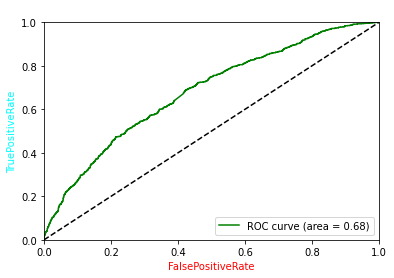

In [0]:


# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc,color='green')
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('FalsePositiveRate',color='red')
pl.ylabel('TruePositiveRate',color='aqua')
pl.title('ROC pre LBP príznaky',color='white')
pl.legend(loc="lower right")
pl.show()


In [0]:
#skusanie nie s predict proba ale s decision function

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
random_state = np.random.RandomState(0)

clf = svm.SVC(kernel='rbf', probability=True, verbose=1)
hog_features = np.vstack((trueidentity, falseidentity)).astype(np.float64)
scaler = StandardScaler().fit(hog_features)
x = scaler.transform(hog_features)
y = np.hstack((np.ones(len(trueidentity)), np.zeros(len(falseidentity))))
x, y = shuffle(x, y, random_state=random_state)

#data_frame = np.hstack((x,y))
#np.random.shuffle(data_frame)

# Training Features...
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
probas_ = clf.fit(x_train,y_train).predict_proba(x_test)
y_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

[LibSVM]

In [0]:
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    # ax1.axis('off')
    # ax1.imshow(img, cmap=plt.cm.gray)
    # ax1.set_title('Input image')
    # hog_image_rescaled = exposure.rescale_intensity(hogimage, in_range=(0, 10))
    # ax2.axis('off')
    # ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    # ax2.set_title('Histogram of Oriented Gradients')
    # plt.show()

In [0]:
from scipy.spatial import distance
eukTrue=[]
eukFalse=[]
for pair in truepair:
  prvy = LBP_face_features.get(pair[0])
  druhy = LBP_face_features.get(pair[1])
  dst = distance.euclidean(prvy, druhy)
  eukTrue.append(dst)

for pair in impostor:
  prvy = LBP_face_features.get(pair[0])
  druhy = LBP_face_features.get(pair[1])
  dst = distance.euclidean(prvy, druhy)
  eukFalse.append(dst)